In [104]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/santander-customer-transaction-prediction/sample_submission.csv
/kaggle/input/santander-customer-transaction-prediction/test.csv
/kaggle/input/santander-customer-transaction-prediction/train.csv


In [105]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import gc
import os
import logging
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold
warnings.filterwarnings('ignore')

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.


/kaggle/input/santander-customer-transaction-prediction/sample_submission.csv
/kaggle/input/santander-customer-transaction-prediction/test.csv
/kaggle/input/santander-customer-transaction-prediction/train.csv


In [ ]:
import pandas as pd
sample_submission = pd.read_csv("../input/santander-customer-transaction-prediction/sample_submission.csv")
test_df = pd.read_csv("../input/santander-customer-transaction-prediction/test.csv")
train_df = pd.read_csv("../input/santander-customer-transaction-prediction/train.csv")

In [ ]:
total = train_df.isnull().sum()
percent = (train_df.isnull().sum())/(train_df.isnull().count())
tt = pd.concat([total,percent],axis = 1,keys = ['total','percent'])
types = []
for col in train_df.columns:
    dtype = str(train_df[col].dtype)
    types.append(dtype)
tt['Types'] = types
np.transpose(tt)
    

In [ ]:
total = test_df.isnull().sum()
percent = (test_df.isnull().sum()/test_df.isnull().count())
tt = pd.concat([total,percent],axis = 1,keys = ['Total','Percent'])
types = []
for col in test_df.columns:
    dtype = str(test_df[col].dtype)
    types.append(dtype)
tt['Types'] = types
np.transpose(tt)

In [ ]:
sns.set_style('whitegrid')
plt.figure()
i = 0
features = ['var_0', 'var_1', 'var_2', 'var_3', 'var_4',
            'var_5', 'var_6', 'var_7', 'var_8', 'var_9', 
            'var_10', 'var_11', 'var_12', 'var_13', 'var_14', 'var_15',]
fig,ax = plt.subplots(4,4,figsize = (14,14))
for feature in features:
    i = i+1
    plt.subplot(4,4,i)
    plt.scatter(train_df[feature],test_df[feature],marker='+')
    plt.xlabel(feature,fontsize = 9)
plt.show()


In [ ]:
sns.set_style('whitegrid')
features = ['var_0', 'var_1', 'var_2', 'var_3', 'var_4',
            'var_5', 'var_6', 'var_7', 'var_8', 'var_9', 
            'var_10', 'var_11', 'var_12', 'var_13', 'var_14', 'var_15',]
plt.figure()
fig,ax = plt.subplots(4,4,figsize = (14,14))
i = 0
for feature in features:
    i = i+1
    plt.subplot(4,4,i)
    plt.scatter(train_df[feature],test_df[feature],marker='^')
    plt.xlabel(feature,fontsize=12)
    
plt.show()

In [ ]:
# checking distribution of target value in the training dataset
sns.countplot(train_df['target'],palette='Set3')
plt.show()

In [ ]:
train_df['target'].value_counts()[1]/train_df.shape[0] * 100

In [ ]:
print('There are {}% target variables with 1'.format((train_df['target'].value_counts()[1]/train_df.shape[0]) * 100))

In [ ]:
train_0 = train_df[train_df['target'] == 0]
train_1 = train_df[train_df['target'] == 1]
features = train_df.columns.values[2:102]
sns.set_style('whitegrid')
plt.figure()
i=0
fig,ax = plt.subplots(10,10,figsize = (25,35))
for feature in features:
     i = i + 1
     plt.subplot(10,10,i)
     sns.distplot(train_0[feature],hist=False,label='zero')
     sns.distplot(train_1[feature],hist=False,label='one')
     plt.xlabel(feature)

In [ ]:
train_0 = train_df[train_df['target'] == 0]
train_1 = train_df[train_df['target'] == 1]
features = train_df.columns.values[102:203]
sns.set_style('whitegrid')
i = 0
plt.figure()
fig,ax = plt.subplots(10,10,figsize = (25,22))
for feature in features:
    i = i+1
    plt.subplot(10,10,i)
    sns.distplot(train_0[feature],label='zero')
    sns.distplot(train_1[feature],label='one')
    plt.xlabel(feature)

In [ ]:
features = train_df.columns.values[2:102]
sns.set_style('whitegrid')
plt.figure()
fig,ax = plt.subplots(10,10,figsize = (35,30))
i = 0
for feature in features:
    i = i + 1
    plt.subplot(10,10,i)
    sns.distplot(train_df[feature],label='train')
    sns.distplot(test_df[feature],label='test')
    plt.xlabel(feature)

In [ ]:
features = train_df.columns.values[102:202]
sns.set_style('whitegrid')
plt.figure()
fig,ax = plt.subplots(10,10,figsize = (35,30))
i = 0
for feature in features:
    i = i+1
    plt.subplot(10,10,i)
    sns.distplot(train_df[feature],label='train')
    sns.distplot(test_df[feature],label='test')
    plt.xlabel(feature)

In [ ]:
# lets check the distribution of mean and standard deviation values per row in the train and test dataset
plt.figure(figsize = (16,6))
features = train_df.columns.values[2:202]
plt.title('Distribution of mean value per row in training and testing dataset')
sns.distplot(train_df.mean(axis=1),kde=True,color='green',bins=120,label='train')
sns.distplot(test_df.mean(axis=1),kde=True,color='blue',bins=120,label='test')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize = (16,6))
plt.title('Distribution of mean values per columns in train and test set')
sns.distplot(train_df[features].mean(axis=0),label='train',kde=True,bins=120)
sns.distplot(test_df[features].mean(axis=0),label='test',kde=True,bins=120)
plt.legend()
plt.show()

In [ ]:
# lets check the distribution of mean and standard deviation values per row in the train and test dataset
plt.figure(figsize = (16,6))
features = train_df.columns.values[2:202]
plt.title('Distribution of standard deviation per row in training and testing dataset')
sns.distplot(train_df.std(axis=1),kde=True,color='black',bins=120,label='train')
sns.distplot(test_df.std(axis=1),kde=True,color='red',bins=120,label='test')
plt.legend()
plt.show()

In [ ]:
# lets check the distribution of mean and standard deviation values per row in the train and test dataset
plt.figure(figsize = (16,6))
features = train_df.columns.values[2:202]
plt.title('Distribution of standard deviation per column in training and testing dataset')
sns.distplot(train_df.std(axis=0),kde=True,color='green',bins=120,label='train')
sns.distplot(test_df.std(axis=0),kde=True,color='red',bins=120,label='test')
plt.legend()
plt.show()

In [ ]:
t0 = train_df.loc[train_df['target'] == 0]
t1 = train_df.loc[train_df['target'] == 1]
plt.figure(figsize = (16,6))
plt.title('Distribution of mean value per row in the train set')
sns.distplot(t0[features].mean(axis=1),label='zero',color='red',kde=True,bins=120)
sns.distplot(t1[features].mean(axis=1),label='one',color='blue',kde=True,bins=120)
plt.legend()
plt.show()

In [ ]:
t0 = train_df.loc[train_df['target'] == 0]
t1 = train_df.loc[train_df['target'] == 1]
plt.figure(figsize = (16,6))
plt.title('Distribution of mean value per column in the train set')
sns.distplot(t0[features].mean(axis=0),label='zero',color='red',kde=True,bins=120)
sns.distplot(t1[features].mean(axis=0),label='one',color='blue',kde=True,bins=120)
plt.legend()
plt.show()

In [ ]:
# lets check the distribution of mean and standard deviation values per row in the train and test dataset
plt.figure(figsize = (16,6))
features = train_df.columns.values[2:202]
plt.title('Distribution of min per column training and testing dataset')
sns.distplot(train_df[features].min(axis=0),kde=True,color='green',bins=120,label='train')
sns.distplot(test_df[features].min(axis=0),kde=True,color='red',bins=120,label='test')
plt.legend()
plt.show()

In [ ]:
# lets check the distribution of mean and standard deviation values per row in the train and test dataset
plt.figure(figsize = (16,6))
features = train_df.columns.values[2:202]
plt.title('Distribution of min per row training and testing dataset')
sns.distplot(train_df[features].min(axis=1),kde=True,color='magenta',bins=120,label='train')
sns.distplot(test_df[features].min(axis=1),kde=True,color='darkblue',bins=120,label='test')
plt.legend()
plt.show()

In [ ]:
# lets check the distribution of mean and standard deviation values per row in the train and test dataset
plt.figure(figsize = (16,6))
features = train_df.columns.values[2:202]
plt.title('Distribution of max per row training and testing dataset')
sns.distplot(train_df[features].min(axis=1),kde=True,color='brown',bins=120,label='train')
sns.distplot(test_df[features].min(axis=1),kde=True,color='yellow',bins=120,label='test')
plt.legend()
plt.show()

In [ ]:
# lets check the distribution of mean and standard deviation values per row in the train and test dataset
plt.figure(figsize = (16,6))
features = train_df.columns.values[2:202]
plt.title('Distribution of max per column training and testing dataset')
sns.distplot(train_df[features].min(axis=0),kde=True,color='magenta',bins=120,label='train')
sns.distplot(test_df[features].min(axis=0),kde=True,color='yellow',bins=120,label='test')
plt.legend()
plt.show()

In [ ]:
t0 = train_df.loc[train_df['target'] == 0]
t1 = train_df.loc[train_df['target'] == 1]
plt.figure(figsize = (16,6))
plt.title('Distribution of min value per row in the train set')
sns.distplot(t0[features].min(axis=1),label='zero',color='orange',kde=True,bins=120)
sns.distplot(t1[features].min(axis=1),label='one',color='darkblue',kde=True,bins=120)
plt.legend()
plt.show()

In [ ]:
t0 = train_df.loc[train_df['target'] == 0]
t1 = train_df.loc[train_df['target'] == 1]
plt.figure(figsize = (16,6))
plt.title('Distribution of min value per column in the train set')
sns.distplot(t0[features].min(axis=0),label='zero',color='orange',kde=True,bins=120)
sns.distplot(t1[features].min(axis=0),label='one',color='red',kde=True,bins=120)
plt.legend()
plt.show()

In [ ]:
t0 = train_df.loc[train_df['target'] == 0]
t1 = train_df.loc[train_df['target'] == 1]
plt.figure(figsize = (16,6))
plt.title('Distribution of max value per row in the train set')
sns.distplot(t0[features].max(axis=1),label='zero',color='brown',kde=True,bins=120)
sns.distplot(t1[features].max(axis=1),label='one',color='yellow',kde=True,bins=120)
plt.legend()
plt.show()

In [ ]:
t0 = train_df.loc[train_df['target'] == 0]
t1 = train_df.loc[train_df['target'] == 1]
plt.figure(figsize = (16,6))
plt.title('Distribution of max value per column in the train set')
sns.distplot(t0[features].max(axis=0),label='zero',color='brown',kde=True,bins=120)
sns.distplot(t1[features].max(axis=0),label='one',color='yellow',kde=True,bins=120)
plt.legend()
plt.show()

lets check distribution of skewness and kurtosis

In [ ]:
plt.figure(figsize = (16,6))
plt.title('Distribution of skew per row in train and test set')
sns.distplot(train_df[features].skew(axis=1),color='red',kde=True,bins=120,label='train')
sns.distplot(test_df[features].skew(axis=1),color='orange',kde=True,bins=120,label='test')
plt.legend()
plt.show()
# we can observe that the elements in the row are highly skewed towards negative direction

In [ ]:
plt.figure(figsize = (16,6))
plt.title('Distribution of skew per col in train and test set')
sns.distplot(train_df[features].skew(axis=0),color='cyan',kde=True,bins=120,label='train')
sns.distplot(test_df[features].skew(axis=0),color='black',kde=True,bins=120,label='test')
plt.legend()
plt.show()
# data anong columns is highly skewed

In [ ]:
t0 = train_df.loc[train_df['target'] == 0]
t1 = train_df.loc[train_df['target'] == 1]
plt.figure(figsize = (16,6))
plt.title('Distribution of skew value per column in the train set')
sns.distplot(t0[features].skew(axis=0),label='zero',color='brown',kde=True,bins=120)
sns.distplot(t1[features].skew(axis=0),label='one',color='yellow',kde=True,bins=120)
plt.legend()
plt.show()

In [ ]:
t0 = train_df.loc[train_df['target'] == 0]
t1 = train_df.loc[train_df['target'] == 1]
plt.figure(figsize = (16,6))
plt.title('Distribution of skew value per row in the train set')
sns.distplot(t0[features].skew(axis=1),label='zero',color='brown',kde=True,bins=120)
sns.distplot(t1[features].skew(axis=1),label='one',color='yellow',kde=True,bins=120)
plt.legend()
plt.show()

feature correlations between features in the training set

In [ ]:
train_df[features].corr().abs().unstack().sort_values(kind='quicksort').reset_index()
# this are the correlated features arranged in asciending order with leart important faetures at the top


In [ ]:
#ten most worstly corelated features
correlations = train_df[features].corr().abs().unstack().sort_values(kind='quicksort').reset_index()
correlations = correlations[correlations['level_0'] != correlations['level_1']]


In [ ]:
#ten most worstly corelated features
correlations.head(10)

In [ ]:
# ten most highly correlated features
correlations.tail(10)

In [ ]:
# lets check how many duplicate values exist per column
features = train_df.columns.values[2:202]
unique_max_train = []
unique_max_test = []
for feature in features:
    values_train = train_df[feature].value_counts()
    unique_max_train.append([feature,values_train.max(),values_train.idxmax()]) # the feature max value repeated how many times and
    #the maximum value in the train set
    values_test = test_df[feature].value_counts()
    unique_max_test.append([feature,values_test.max(),values_train.idxmax()])# the feature max value,max value in the feature rep
    #eated how many times,maximum value
#the above values we are inserting tn the arrays are maximum duplicate values
#because pandas values count function gives us how many same values exists
#this are the
np.transpose(pd.DataFrame(unique_max_train,columns = ['features','max_duplicates','value']).sort_values(by = 'max_duplicates',ascending = False))

In [ ]:
np.transpose(pd.DataFrame(unique_max_test,columns = ['features','max_feature_values','value']).sort_values(by = 'max_feature_values',ascending = False))

In [ ]:
#we can observe that same columns in the train and test set have have same or very colse number of duplicates of same or very close values which can 
#be used in the future for classification

In [ ]:
idx = features = train_df.columns.values[2:202]
train_df['sum'] = train_df[idx].sum(axis=1)
train_df['min'] = train_df[idx].min(axis=1)
train_df['max'] = train_df[idx].max(axis=1)
train_df['mean'] = train_df[idx].mean(axis=1)
train_df['std'] = train_df[idx].std(axis=1)
train_df['skew'] = train_df[idx].skew(axis=1)
train_df['kurt'] = train_df[idx].kurt(axis=1)
train_df['med'] = train_df[idx].median(axis=1)


In [ ]:
train_df.iloc[:,202:]

In [ ]:
idx = features = test_df.columns.values[1:201]
test_df['sum'] = test_df[idx].sum(axis=1)
test_df['min'] = test_df[idx].min(axis=1)
test_df['max'] = test_df[idx].max(axis=1)
test_df['mean'] = test_df[idx].mean(axis=1)
test_df['std'] = test_df[idx].std(axis=1)
test_df['skew'] = test_df[idx].skew(axis=1)
test_df['kurt'] = test_df[idx].kurt(axis=1)
test_df['med'] = test_df[idx].median(axis=1)


In [ ]:
test_df.iloc[:,201:]

In [ ]:
idx

In [ ]:
# for training data
t0 = train_df[train_df['target'] == 0]
t1 = train_df[train_df['target'] == 1]
features = train_df.columns.values[202:]
sns.set_style('whitegrid')
i = 0
plt.figure()
fig,ax = plt.subplots(2,4,figsize = (18,8))
for feature in features:
    i = i+1
    plt.subplot(2,4,i)
    sns.kdeplot(t0[feature],label='zero',bw=0.5)
    sns.kdeplot(t1[feature],label='one',bw=0.5)
    plt.xlabel(feature)
plt.show()

In [ ]:
# new features for training and testing data
# for training data
features = train_df.columns.values[202:]
sns.set_style('whitegrid')
i = 0
plt.figure()
fig,ax = plt.subplots(2,4,figsize = (18,8))
for feature in features:
    i = i+1
    plt.subplot(2,4,i)
    sns.kdeplot(train_df[feature],label='train',bw=0.5)
    sns.kdeplot(test_df[feature],label='test',bw=0.5)
    plt.xlabel(feature)
plt.show()

In [ ]:
features = [c for c in train_df.columns.values if c not in ['ID_code','target']]

In [ ]:
train_df_2 = pd.DataFrame()
test_df_2 = pd.DataFrame()
train_df_1 = pd.DataFrame()
test_df_1 = pd.DataFrame()

In [ ]:
features = [c for c in train_df.columns.values if c not in ['ID_code','target']]
for feature in features:
    train_df_2['r2_',feature] = np.round(train_df[feature],2)
    test_df_2['r2_',feature] = np.round(test_df[feature],2)
    train_df_1['r1_',feature] = np.round(train_df[feature],1)
    test_df_1['r1_',feature] = np.round(test_df[feature],1)

In [ ]:
features = [c for c in train_df.columns.values if c not in ['ID_code','target']]
target = train_df['target']

In [75]:
X_train = train_df[features]
X_test = test_df[features]
y_train = target.values.reshape(-1,1)

In [ ]:
X_train

In [82]:
from sklearn.preprocessing import QuantileTransformer
qt = QuantileTransformer()
X_train = qt.fit_transform(X_train)
X_test = qt.fit_transform(X_test)

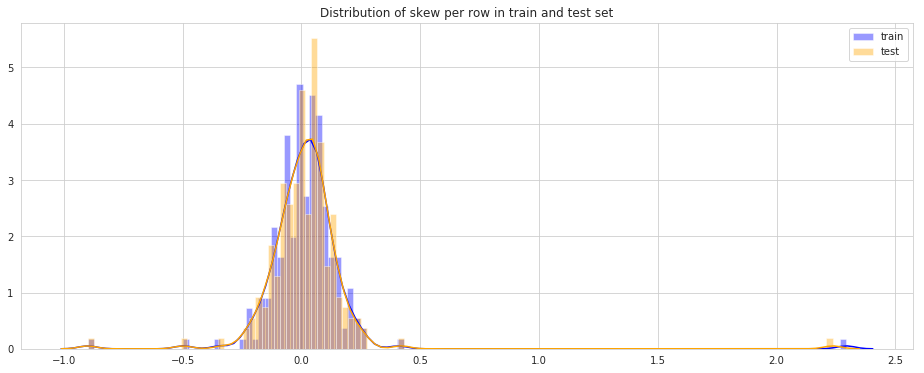

In [83]:
plt.figure(figsize = (16,6))
plt.title('Distribution of skew per row in train and test set')
sns.distplot(train_df[features].skew(axis=0),color='blue',kde=True,bins=120,label='train')
sns.distplot(test_df[features].skew(axis=0),color='orange',kde=True,bins=120,label='test')
plt.legend()
plt.show()
# we can observe that the elements in the row are highly skewed towards negative direction

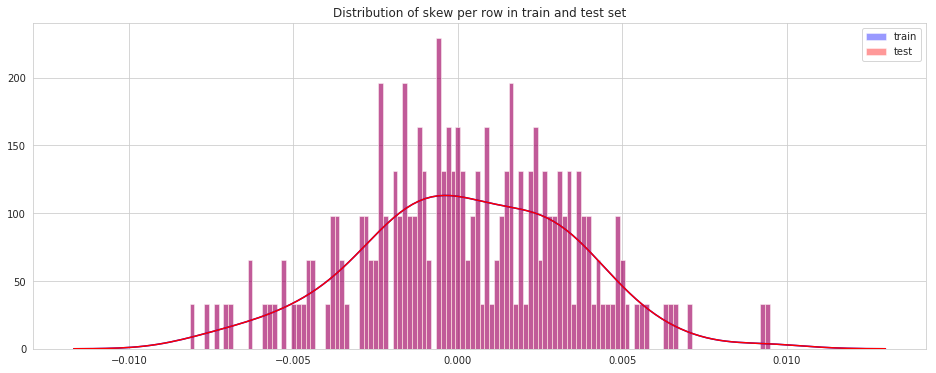

In [86]:
plt.figure(figsize = (16,6))
plt.title('Distribution of skew per row in train and test set')
sns.distplot(pd.DataFrame(X_train).skew(axis=0),color='blue',kde=True,bins=120,label='train')
sns.distplot(pd.DataFrame(X_train).skew(axis=0),color='red',kde=True,bins=120,label='test')
plt.legend()
plt.show()
# we can observe that the elements in the row are highly skewed towards negative direction

In [90]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
clf.fit(X_train,y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

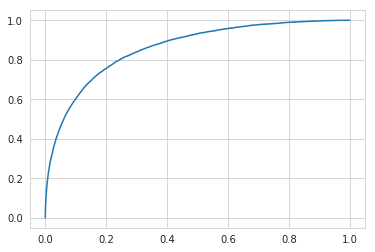

In [96]:
from sklearn.metrics import roc_curve,auc
X_proba = clf.predict_proba(X_train)[:,1]
fpr,tpr,thr = roc_curve(y_train,X_proba)
plt.plot(fpr,tpr)

In [99]:
from sklearn.model_selection import cross_val_score
cross_val_score(clf,X_train,y_train,cv=10,scoring = 'roc_auc').mean()

0.8575848157629012

In [101]:
from sklearn.model_selection import cross_val_score
cross_val_score(clf,X_train,y_train,cv=10,scoring = 'accuracy').mean()

0.9131200144133

In [102]:
y_pred = clf.predict(X_test)

In [103]:
y_pred

array([0, 0, 0, ..., 0, 0, 0])